# <div style="text-align: center"> **Corso di Strutture Dati e Algoritmi** </div> 
## <div style="text-align: center"> Analisi di algoritmi di Sorting </div> 
***
## <div style="text-align: right"> Edoardo Tronconi </div> <div style="text-align: right"> n. matricola: 975734 </div>

***
## Importo librerie necessarie

In [1]:
import os
import subprocess
import glob
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:
plt.rcParams.update({
    'figure.figsize' : [15,10],
    'font.size' : 15,
})

***
## Mi sposto nella cartella in cui è presente `main.x`
###### (Necessario in quanto `main.x` produce output di testo con un percorso relativo alla cartella dell'eseguibile c++, e `subprocess.run()` necessita di percorsi relativi alla cartella in cui "si trova" il notebook [[stackoverflow.com](https://stackoverflow.com/questions/39741422/python-subprocess-not-writing-output-files)] )

In [3]:
try:
    NBdir
except:
    NBdir = os.path.realpath('.')
    CPPdir = os.path.join(NBdir[:-9],'c++')

try: 
    os.chdir(CPPdir)
    if os.getcwd()[-15:] != 'ProgettoSDA/c++':
        raise Exception()
except:
    raise RuntimeError("Cartella sbagliata! Non posso eseguire ./main.x")

***
# Misuro i tempi
test(*args) produce un dizionario con i dati del test:

* key = (string algoritmo, int size, bool random, bool ordinato, bool pochiValori)
* value = array contenente i tempi per ciascuno dei trials effettuati

In [144]:
#algoritmi
ALGOS = ['STLsort','Insertionsort','Quicksort','Mergesort','Heapsort']


def key_from_args(algo,*argsMain):
    key = [algo]
    for arg in argsMain:
        if arg.find('-size=') != -1:
            key.append(int(arg[6:]))
    if ('--randomized' in argsMain) or ('-r' in argsMain):
        key.append(True)
    else:
        key.append(False)

    if ('--sorted' in argsMain) or ('-s' in argsMain):
        key.append(True)
    else:
        key.append(False)

    if ('--fewUnique' in argsMain):
        key.append(True)
    else:
        key.append(False)
    return tuple(key)
    
    
def test(*argsMain):
    subprocess.run(['make','cleanRes']) #elimino i .txt precedenti così non devo cercare il file di output giusto tra molti
    subprocess.run(['./main.x', *argsMain]) #eseguo con gli argomenti passati
    
    #salvo per ogni algorimo i risultati in un dizionario
    result = {}
    for algo in ['STLsort','Insertionsort','Quicksort','Mergesort','Heapsort']:
        tempi = np.loadtxt(glob.glob('./Risultati/'+algo+'/*.txt')[0], delimiter='\n', dtype=int)
        result.update( {key_from_args(algo, *argsMain) : tempi} )
    return result
    
def filter_results(results, K): #filtra i risultati con key = K = (algo, size, random, sorted, pochiVal) ['*' = tutti]
    output = results
    for i,key in enumerate(K):
        if key != '*':
            output = dict(filter(lambda item: (item[0][i]==key), output.items()))
    return output

def plot_times(results, *, Algos, Sizes, Random=False, Sorted=False, FewUnique=False ): #args = (bool, bool, bool) per (randomized, sorted, fewUniques)
    plt.figure()
    for algo in Algos:
        Xs = []
        Ys = []
        Xmean = []
        Ymean = []
        for size in Sizes:
            y = list(filter_results(results, (algo,size,Random, Sorted, FewUnique)).values())[0]
            ymean = sum(y)/len(y)
            
            Ys.append(y)
            Ymean.append(ymean)
            
            Xs.append([size]*len(y))
            Xmean.append(size)
            
        label = 'Randomized Quicksort' if ( (algo=='Quicksort') and (Random) ) else algo
        plt.scatter(Xs,Ys, s=10, label= label)

        plt.plot(Xmean, Ymean, lw=2, alpha=0.2)
        
        plt.xlabel('Dimensione Vettore')
        plt.ylabel('Tempo esecuzione [ns]')
        
        rndQS = '' #' (Randomized Quicksort)' if Random else ''
        ordinato = " gia' ordinato" if Sorted else ''
        pochi = ' con pochi elementi diversi' if FewUnique else ''

        
        plt.title('Tempo di Ordinamento vettore'+ordinato+pochi+rndQS)
    plt.legend()

#### Caricamento rapido risultati

In [139]:
results = load(NBdir+'/results.zip')

### Ottengo dizionario `results`
#### Argomenti di ./main.x


```
'-trials=...'           -> ... = numero di prove (default 1)
'-size=...'             -> ... = dimensione vettore (default 1000)
'-seed=...'             -> ... = seed generatore numeri casuali (o '-seed=time' per srand(time(NULL)) )
'-algo=...'             -> ... = algoritmo da testare (opzioni: STL, QS, IS, MS, HS o '-algo=all' per testarli tutti (default))

'--randomized' o '-r'   -> usa randomized quicksort (default false)
'--sorted'     o '-s'   -> ordina un vettore già ordinato (default false)
'--file'       o '-f'   -> stampa su file il risultato (default false)
'--verbose'    o '-v'   -> stampa su terminale riepilogo (default false)
'--fewUnique'           -> ordina un vettore con pochi valori distinti (default false)
'--debug'               -> controlla se gli algoritmi di ordinamento funzionano e stampa errore in caso contrario
```

In [102]:
#dimensioni del vettore da provare
SIZES = [10,50,100,250,500,750,1000,2000,3000,4000,5000]

#parametri del main da usare sempre
BASE_ARGS = [
    '-trials=50',
    '-seed=420',
    '--file',
]

#parametri del main aggiuntivi da provare
ARGS_MAIN = [
     [],
     ['--randomized'],
     ['--sorted'],
     ['--fewUnique'],
     ['--randomized','--sorted'],
     ['--randomized','--fewUnique'],
     ['--sorted', '--fewUnique'],
     ['--randomized','--sorted','--fewUnique'],
]

In [103]:
results = {}
subprocess.run('make') #se fosse necessario costruisco l'eseguibile
for size in SIZES:
    for argsMain in ARGS_MAIN:
        ARGS = [*BASE_ARGS, *argsMain, '-size='+str(size)]
        results.update(test(*ARGS))

***
# Grafici

In [130]:
ALGORITMI = ['Quicksort', 'Mergesort', 'Heapsort']

#### Tempi su vettori casuali

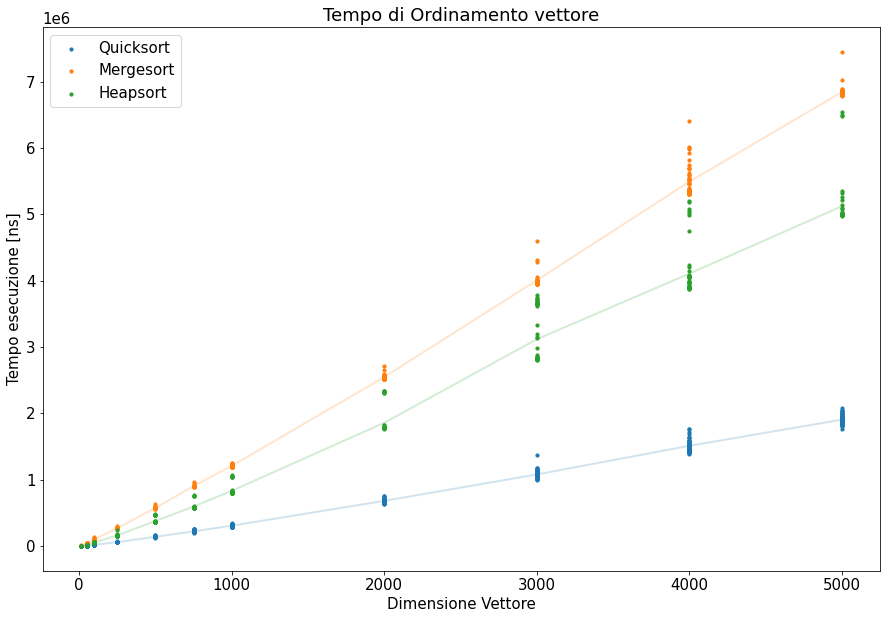

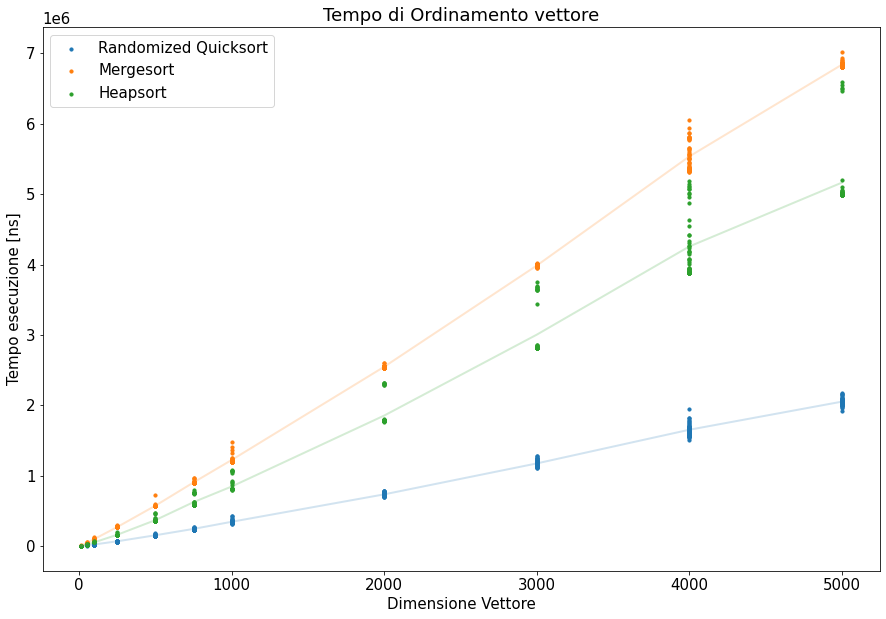

In [146]:
plot_times(results, Algos=ALGORITMI, Sizes=SIZES)
plot_times(results, Algos=ALGORITMI, Sizes=SIZES, Random=True)

#### Tempi su vettori già ordinati

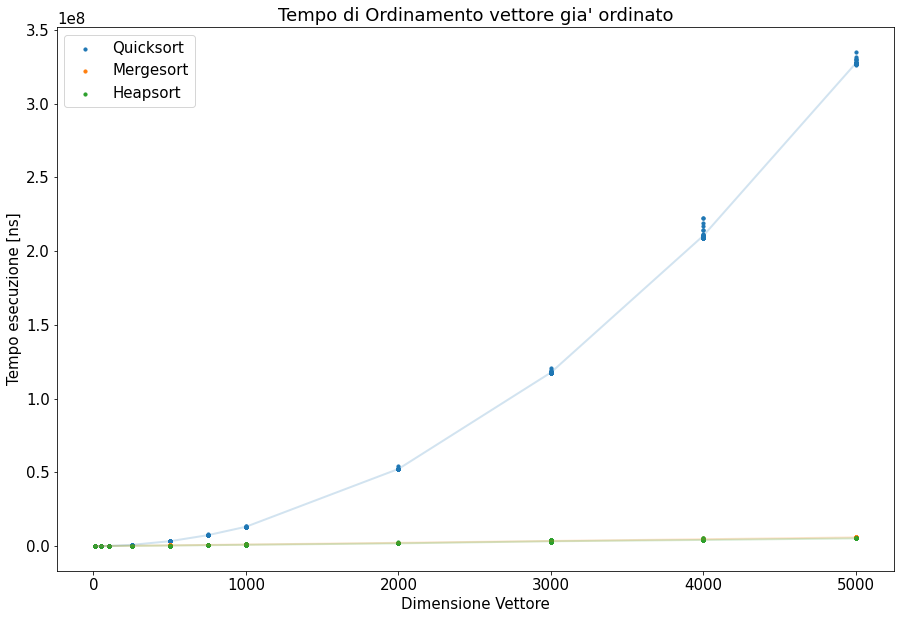

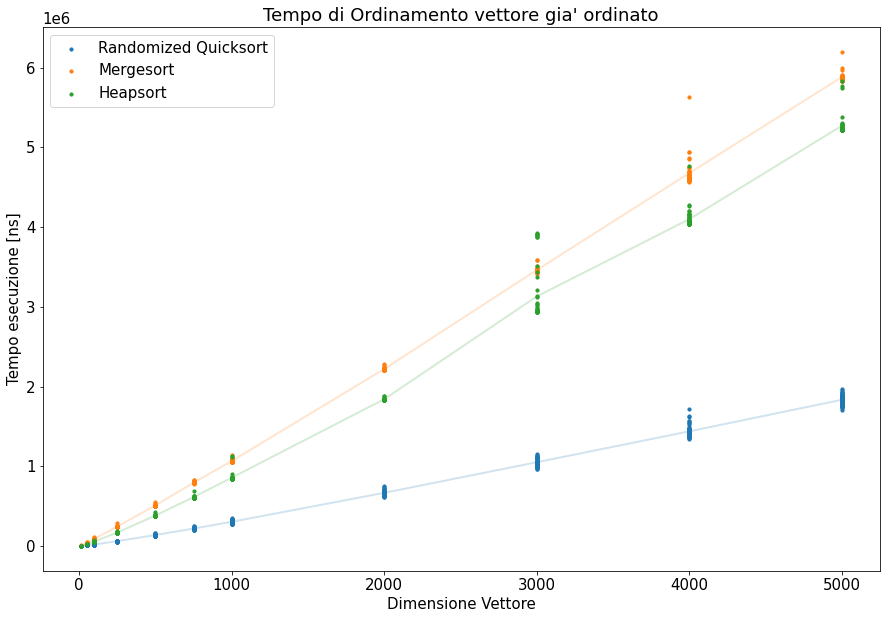

In [147]:
plot_times(results, Algos=ALGORITMI, Sizes=SIZES, Sorted=True)
plot_times(results, Algos=ALGORITMI, Sizes=SIZES, Random=True, Sorted=True)

#### Tempi su vettori con pochi elementi diversi

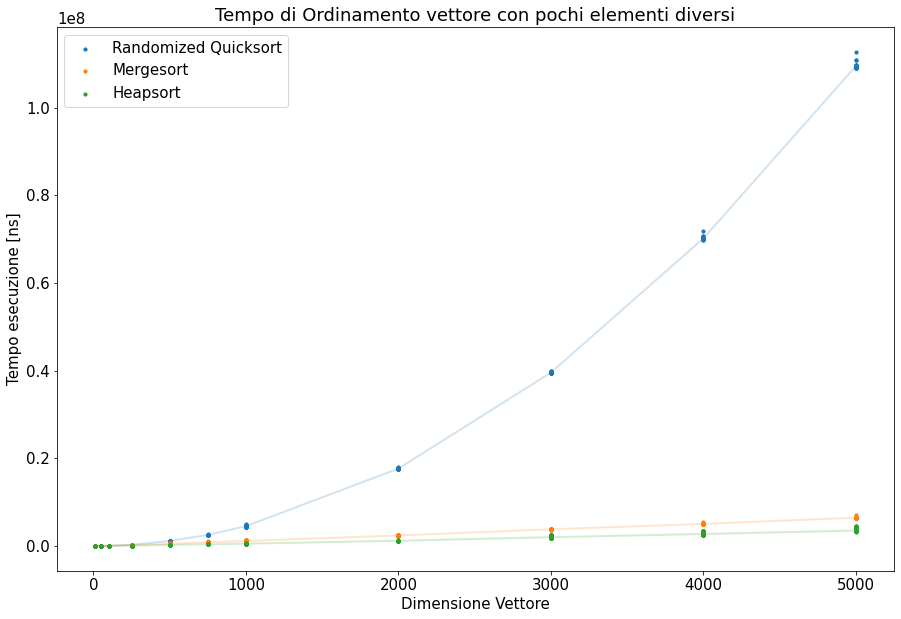

In [148]:
plot_times(results, Algos=ALGORITMI, Sizes=SIZES, Random=True, FewUnique=True)

***